# Counting Bloom Filters
## Overview

Counting Bloom Filters are an extension of the original Bloom Filter, a space-efficient data structure. Counting Bloom Filters fulfil the same purpose, to provide a solution to the set membership problem. However, they are able to perform beyond the operations **INSERT** and **QUERY**. They can also **DELETE** without rehashing the entire set. The only change to the data structure is that the filter uses counters instead of booleans as their primary building block.

## Operations

**INSERT**
Populates Bloom Filter by hashing items to be added, and incrementing corresponding counters by one.

**QUERY**
Finds whether an item is part of the set by checking whether the counters at corresponding hash values are greater than one. False positives are still a tradeoff, but the rate can be controlled by appropriate space allocation.

**DELETE**
Decrements counters at hash values of an item. Allows removing an element from the hash without having to rehash the entire filter.

## Applications
While using counters instead of booleans increases the use of space, its increased functionality makes it suitable for multiple applications.

### Recommendations
Multiple media platforms such as YouTube or Netflix are motivated to show their users new content. They use Bloom filters to store what movies or videos the user has watched, and can with 100% accuracy return content that is yet unseen. However, often viewers don't fully watch a video, and in this case, it is a good strategy to return that content to them again. This requires the deletion of an element from the bloom filter, which a Counting Bloom Filter can achieve.

### Browser Cache  Optimisation
We use our computers so much that it is worth for a browser to store some data of the pages that we visit regularly. Counting Bloom Filters are a perfect tool to keep track of the set of websites that we visit regularly, and according to our habits insert, query and delete the name of websites to be stored in the cache.

# Implementation

In [126]:
''' Counting Bloom Filter

This is a binary bitarray implementation of the CBF,
it uses significantly (~x3-4) less space than a list based method would.

Parameters:
- m: length of the bitarray
- b: size of 'buckets', number of bits

Hash functions:
- I designed the hash functions for this CBF based on our
analysis of efficiency in session 8.2
-I created hashing() that takes a tuple of a key and a seed
and returns a uniform hashvalue
-I used 4 different prime seeds to have independent hashes

'''
from bitarray import bitarray
import math, string

class CountingBloom(object):
    def __init__(self,m,b):
        self.m=m #length of bitarray
        self.b=b #size of buckets
        self.nb=self.m/self.b #number of buckets in the bitarray
        self.bitarray=bitarray()
        self.zerofill()
    
    def zerofill(self):
        #fill bitarray with zeros for length m
        for i in range(self.m):
            self.bitarray.append(0)
    
    def position(self,hashfunction,key):
        #returns position of bitarray for hashed key
        former_beginning = hashfunction(key)
        if former_beginning == 0:
            beginning = 0
        else:
            beginning=former_beginning*self.b-self.b
        former_end = hashfunction(key)
        if former_end == 0:
            end = self.b
        else:
            end=former_end*self.b
        return int(beginning),int(end)
    
    def hashing(self,key,seed):
        ans = 0
        for chr in key:
            ans = ans * 128 + ord(chr)
        ans=ans ^ seed
        
        return ans%self.nb
    
    def hash1(self,key):
        return self.hashing(key,11)
    
    def hash2(self,key):
        return self.hashing(key,17)
    
    def hash3(self,key):
        return self.hashing(key,23)
    
    def hash4(self,key):
        return self.hashing(key,37)      
    
    def add(self,x,y):
        #binary addition of x and y
        x=x.to01() #bitarray string
        x=int(x,2)
        summa=x+y #sum
        return bitarray(format(summa, '08b'))
    
    def insert(self,key):
        #increments bucket by one if key hashes to bucket
        p,r=self.position(self.hash1,key)
        self.bitarray[p:r]=self.add(self.bitarray[p:r],1)
        p,r=self.position(self.hash2,key)
        self.bitarray[p:r]=self.add(self.bitarray[p:r],1)
        p,r=self.position(self.hash3,key)
        self.bitarray[p:r]=self.add(self.bitarray[p:r],1)
        p,r=self.position(self.hash4,key)
        self.bitarray[p:r]=self.add(self.bitarray[p:r],1)        

    
    def query(self,key):
        #returns true if finds buckets >0 at hash values
        p,r=self.position(self.hash1,key)
        string=self.bitarray[p:r].to01()
        if int(string,2)<1:
            return False
        p,r=self.position(self.hash2,key)
        string=self.bitarray[p:r].to01()
        if int(string,2)<1:
            return False
        p,r=self.position(self.hash3,key)
        string=self.bitarray[p:r].to01()
        if int(string,2)<1:
            return False
        p,r=self.position(self.hash4,key)
        string=self.bitarray[p:r].to01()
        if int(string,2)<1:
            return False

        return True
    
    def delete(self,key):
        #decrements buckets, which key hashes to
        #query if key in filter, prevents false negatives
        if self.query(key):
            p,r=self.position(self.hash1,key)
            self.bitarray[p:r]=self.add(self.bitarray[p:r],-1)
            p,r=self.position(self.hash2,key)
            self.bitarray[p:r]=self.add(self.bitarray[p:r],-1)
            p,r=self.position(self.hash3,key)
            self.bitarray[p:r]=self.add(self.bitarray[p:r],-1)
            p,r=self.position(self.hash4,key)
            self.bitarray[p:r]=self.add(self.bitarray[p:r],-1)


Now that we have set up our Counting Bloom Filter Object, we want to create a function that takes a list of items and constructs a filter from them. 

In [127]:
def CountingBloomFilter(items,b,m):
    '''
    Function populates CBF with items.
    
    Parameters:
    -m is the bitarray length
    -b is the bucket size in bits
     
    I will utilise this function to test the space complexity of CBF.
    
    '''
    if m%b != 0:
        raise ValueError('bitarray size is not divisible by bucket size')
    
    CBF=CountingBloom(m,b)
    for item in items:
        CBF.insert(item)
    
    return CBF

# Time and Space Complexity Analysis
We should first want to specify a couple of functions that will help us in our analysis.

In [128]:
import time, random
def memory_size(cbf):
    '''
    The only non-static element in our object is self.bitarray,
    which is the filter itself.
    
    As this is the only element that will change upon different
    input sizes, it is representative of the total memory use,
    especially at large input lengths.
    
    This function returns the size of the bitarray filter in bits.
    
    '''
    bitarray=cbf.bitarray
    return bitarray.buffer_info()[1]

def access_time(cbf,keys):
    '''
    This function calculates an average access time.
    
    It will take n number of keys, and measure the mean
    of the time the query method takes to return an answer.
    '''
    total=[]
    start_time = time.time()
    cbf.query(keys[1])
    total.append(time.time() - start_time)
    return sum(total)/len(total)

def false_positive(cbf,keys):
    '''
    Given a filter object and a set of keys, this function
    will generate a set of keys "not in" keys and query them all.
    
    Function keeps count of Trues returned by query,
    and calculates a false positive rate.
    '''
    newkeys=[]
    while len(newkeys)!=len(keys):
        word=randomword(10)
        if word not in keys:
            newkeys.append(word)
    
    counter=0
    for newkey in newkeys:
        if cbf.query(newkey):
            counter+=1
    
    return counter/len(keys)
    
def randomword(length):
    '''
    Random word generator from Pre-class work, session 7.2.
    '''
    return ''.join(random.choice(string.ascii_lowercase) for i in range(length))


To analyse the time and space complexity of the relationship of our parameters, let's use the following to represent our variables:

* $n$ memory size of the filter.
* $b$ number of buckets
* $k$ number of hash functions.
* $m$ number of set elements in the filter.
* $p$ the false positive rate

## Memory size as a function of the false positive rate

Our memory size, $n$ is going to be a constant multiple of the number of buckets in the filter. In fact, in this bit array implementation it is 8 bits the number of buckets, thus $n=8b$ $bits$.

We know that the false positive rate is going to depend on the ratio of elements in the filter and the memory size of the filter, such that in general terms $p=m/n$.

Thus, for a fixed input size of $m$, we expect the memory size to scale in terms of the false positive rate, such that $n=1/p$. The plot below confirms the nature of this relationship.

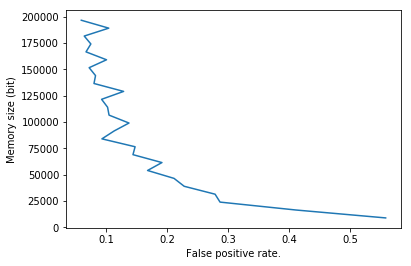

In [125]:
import matplotlib.pyplot as plt

'''
This cell creates a plot of memory size vs false positive rate by manipulating-
the size of the CBF in a loop and averaging the memory-size and false positive rate
results.
'''

x=[]
y=[]
for i in range(200000,0,-500):
    words=[randomword(10) for k in range(1000)]
    cbf=CountingBloomFilter(words,8,8*i)
    y.append(memory_size(cbf))
    x.append(false_positive(cbf,words))

x1=[]
y1=[]
for i in range(0,len(x)-15,15):
    temp=sum(x[i:i+15])/len(x[i:i+15])
    x1.append(temp)
    temp2=sum(y[i:i+15])/len(y[i:i+15])
    y1.append(temp2)
    
plt.xlabel("False positive rate.")
plt.ylabel("Memory size (bit)")
plt.plot(x1,y1)
plt.show()  

## Number of items as a function of the false positive rate

Similarly to the question above, the number of items as a function of the false positive rate will scale according to $p=m/n$. 

However, in this case, we have our memory size $n$ fixed, so the general relationship between the number of items and the false positive rate will be a linear function $m=p$. 

This theoretical observation is confirmed in the plot below, which exhibits a linear relationship with a slight increase in the number of items before the maximum false positive rate of $1$ is reached. 

This is most probably due to underperforming hash functions, as new items are hashed over others instead of uniformly spanning the filter. But the results are close enough for us to confirm the above theoretical relationship.


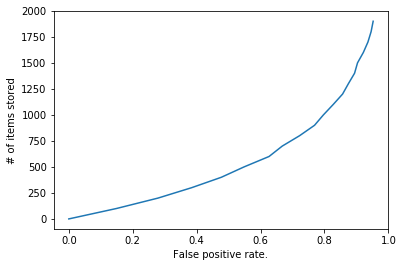

In [6]:
'''
This cell plots # items stored vs false positive rate
by manipulating the # items in an incrementing for loop
and averages the results.

'''
x=[]
y=[]
for i in range(0,2000,100):
    temp1=[]
    temp2=[]
    for j in range(20):
        words=[randomword(10) for k in range(i+1)]
        cbf=CountingBloomFilter(words,8,160000)
        temp1.append(len(words))    
        temp2.append(false_positive(cbf,words))
    x.append(sum(temp2)/len(temp2))
    y.append(sum(temp1)/len(temp1))
plt.xlabel("False positive rate.")
plt.ylabel("# of items stored")
plt.plot(x,y)
plt.show()  

## Access time as a function of the false positive rate

We expect the access time, i.e. the average time of query, of our Counting Bloom Filter to be the same regardless of the false positive rate, which is linked to the ratio of items and memory size.

This is because our **QUERY** function only performs  $O(1)$ operations for the four hash functions:
* calculate the hash value of a key
* calculate the position of hash value in the bit array
* compare if bit array position > 1

None of these functions' complexity is going to be affected by the memory or the input item size, thus the constant false positive rate. This is confirmed in our graph below.

We see spikes at 10ms and the rest of our access times are 0. This is because the Jupyter **time** module we used cannot measure runtime under 8ms in x64 machines. Thus we can say that our access time is constant that fluctuates between 0-10ms. 

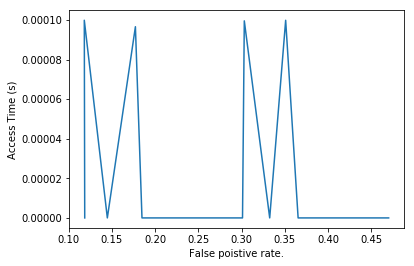

In [109]:
'''
This cell times the access of a single query of CBFs
with different false positive rates. It averages the times
and false positive rates before plotting.

'''

x=[]
y=[]
for i in range(200,1200,50):
    tempx=[]
    tempy=[]
    words=[randomword(10) for k in range(i)]
    cbf=CountingBloomFilter(words,8,30000)
    for j in range(10):
        tempx.append(false_positive(cbf,words))
        start_time = time.time()
        cbf.query(words[15])
        tempy.append(time.time() - start_time)
    x.append(sum(tempx)/len(tempx))
    y.append(sum(tempy)/len(tempy))

plt.xlabel("False poistive rate.")
plt.ylabel("Access Time (s)")
plt.plot(x,y) 

## Access time as a function of the number of items stored

As explained above, the access time will not depend on the number of items nor the memory size of the bit array.

Our graph below confirms the $O(1)$ complexity of access.

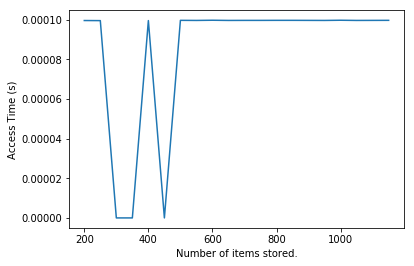

In [88]:
'''
This cell times the access of a single query of CBFs with
different number of items stored. It averages the results
before plotting.

'''

x=[]
y=[]
for i in range(200,1200,50):
    tempx=[]
    tempy=[]
    words=[randomword(50) for k in range(i)]
    cbf=CountingBloomFilter(words,8,36000)
    for j in range(10):
        tempx.append(len(words))
        start_time = time.time()
        cbf.query(words[15])
        tempy.append(time.time() - start_time)
    x.append(sum(tempx)/len(tempx))
    y.append(sum(tempy)/len(tempy))

plt.xlabel("Number of items stored.")
plt.ylabel("Access Time (s)")
plt.plot(x,y)

# Corner Cases

## Optimal Case of False Positives

A bucket being addressed by a hash function has the probability of $P=1/b$, where $b$ is the number of buckets. This is the best case as it assumes that our hash function can uniformly span the entire filter. From this, it follows that the probability of a bucket not being addressed is $P=1-1/b$.

This means that for four hash functions, as in this implementation, the probability of a bucket not having been addressed is $P=(1-1/b)^4$. Consequently, the probability that a bucket remains empty after $m$ items have been placed into the filter is $P_{empty}=(1-1/b)^{4m}$. Thus the probability that a bucket is hashed to after inserting all the items is $P_{nonempty}=1-P_{empty}$.

Thus the false positive rate or the probability of every bucket being hashed to is $P_{error}=(1-(1-1/b)^{4m})^4=(1-e^{-4m/b})^k$.

The equation that will minimise this rate is $4=\frac{b}{m} ln(2)$. Thus the optimal ratio between the number of buckets $b$ and the number of items $m$ inserted is $\frac{b}{m}\approx 5.77$ with four hash functions.

## Worst Case

Hash functions that do not uniformly and independently map the filter will result in more collisions and thus can increase our false positive rate. A potential worst-case scenario is if the hash functions map every element to the same buckets. Thus the probability of mapping onto the same buckets is $P=1$, and thus our false positive error rate is $P_{error}=1$, as an additional element not originally part of the set would map to the same buckets.

Also, it might happen that our buckets overflow and we are not able to increment the bucket any further. In such a case an additional map to the bucket would not be noticed (or would raise an error in a good code implementation) and thus upon deletion, we could run into the problem of false negatives.

A third potential drawback of Counting Bloom Filters is if we are deleting an item from the filter that has not been part of the set. If the item is not queried beforehand, this could result in us decrementing buckets of actual set members, thus resulting in false negatives.

# HC Applications
**#modeling:** In this assignment I accurately identified the workings of the Bloom Filter data structure, and explained how it is a functional model to solve the set-membership problem. Following this, I developed a Counting Bloom Filter with extended utility over the original model. During my construction of the model, I paid particular attention to implement it in the most efficient manner (I used binary arrays vs lists for better performance).

**#constraints:** This assignment required me to dig deeper into understanding binary representation of the data and identify obstacles these basic constraints of machine impose on the computer scientist. I developed methods to go around these constraints (e.g. binary addition method in my CBF object) and utilised the simplicity of the binary bit array to make an efficient data structure.

# References
*For the theoretical analysis of Bloom Filters I have relied on the following resources*
1. Blustein, J., & El-Maazawi, A. (2002). Bloom filters. a tutorial, analysis, and survey. Halifax, NS: Dalhousie University, 1-31.
2. Bloom filter. (2019, February 04). Retrieved from https://en.wikipedia.org/wiki/Bloom_filter
